In [258]:
import torch
from torch import nn, tensor, optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SubsetRandomSampler, WeightedRandomSampler

import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import precision_recall_curve, roc_curve

from Xas2Quality_dataloader import *
from Xas2Quality_model import *
from Xas2Quality_trainer import *

%reload_ext autoreload
%autoreload 1
%aimport Xas2Quality_dataloader, Xas2Quality_model, Xas2Quality_trainer, seaborn

from torch.utils.tensorboard import SummaryWriter

## Reading data and derivative

In [377]:
spec.data.shape

(8434, 299)

In [263]:
spec = Xas2QualityDataset.from_file(spec_file="e7600-8000_grid400_spec_norm.pkl",
                                    quality_file="e7600-8000_grid400_prediction.pkl",
                                    balance=True,
                                    energy_cut=(7600,7900))

Orignal | Label_1: 8171, Label_0: 4217
Balanced | Label_1: 4217.0; Label_0: 4217.0
Feature size: 299


In [249]:
# load normalized spec data from file
with open("e7600-8000_grid400_spec_norm.pkl",'rb') as f:
    spec_norm = pickle.load(f)
red_norm = spec_norm['spec']
feature_grid = spec_norm['feature_grid']

# load from file quality labels (1 or 0) for normalized spec data
with open("e7600-8000_grid400_prediction.pkl",'rb') as f:
    result = pickle.load(f)
labels = result['label']
sets = np.array(result['set'])

select_feature = (feature_grid>7600)&(feature_grid<7900)
select_test = (sets=='test')

In [250]:
test_norm = red_norm[select_test][:, select_feature]
test_label = labels[select_test]

In [228]:
label_1 = (spec.label > 1-1e-1).astype(float)
label_0 = (spec.label < 0+1e-1).astype(float)
weights = label_1 + label_0 * label_1.sum() / label_0.sum()

batch_size = 2000
sampler = WeightedRandomSampler(weights, batch_size, replacement=False)
sampled_label = [spec.label[idx] for idx in list(sampler)]
np.array(sampled_label).sum()

1028.9999992768853

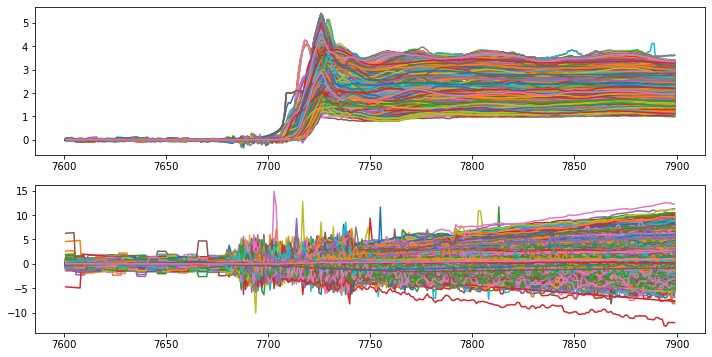

In [264]:
fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(spec.feature, spec.data[(spec.label==1).reshape(-1)].T)
axs[1].plot(spec.feature, spec.data[(spec.label==0).reshape(-1)].T)
plt.show()

#### Some useful links
https://discuss.pytorch.org/t/difference-between-nn-linear-nn-crossentropyloss-and-nn-logsoftmax-nn-nllloss/21634

In [265]:
portion = [0.7, 0.2, 0.1]
N_samples = len(spec)
N_train = int(np.ceil(N_samples * portion[0]))
N_val = int(np.ceil(N_samples * portion[1]))
N_test = N_samples - N_train - N_val
assert N_samples == N_train + N_val + N_test

dtype = torch.float
device = torch.device("cuda")

d = spec.data
l = spec.label
x_train = tensor(d[:N_train],dtype=dtype,device=device)
y_train = tensor(l[:N_train],dtype=dtype,device=device).reshape(-1,1)

x_val = tensor(d[N_train:N_train+N_val],dtype=dtype,device=device)
y_val = tensor(l[N_train:N_train+N_val],dtype=dtype,device=device).reshape(-1,1)

x_test = tensor(d[-N_test:],dtype=dtype, device=device)
y_test = tensor(l[-N_test:],dtype=dtype, device=device).reshape(-1,1)

x_test_loss = tensor(test_norm, dtype=dtype, device=device)
y_test_loss = tensor(test_label, dtype=dtype, device=device)


print("Data shape for: Training | Validation | Test")
print("data:", x_train.size(),  x_val.size(), x_test.size())
print("label:", y_train.size(),  y_val.size(), y_test.size())

assert y_train.size()[0] == N_train
assert y_val.size()[0] == N_val
assert y_test.size()[0] == N_test

dd = {'train': (x_train, y_train),
         'val': (x_val, y_val),
         'test': (x_test, y_test)}

Data shape for: Training | Validation | Test
data: torch.Size([5904, 299]) torch.Size([1687, 299]) torch.Size([843, 299])
label: torch.Size([5904, 1]) torch.Size([1687, 1]) torch.Size([843, 1])


In [266]:
def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()

def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

model = Xas2QualityFCN(input_size=299, output_size=1, dropout_rate=0.4)
model.apply(weight_reset)

trainer = Trainer(model, dd, device=torch.device("cuda"), verbose=True, learning_rate=1e-4,
                  max_epochs=1000, batch_size=200,board=False)

train_loss, val_loss = trainer.train((x_test_loss, y_test_loss))

Tensorboard is off
Epoch 100/1000 | loss: 0.118/0.127
Epoch 200/1000 | loss: 0.079/0.090
Epoch 300/1000 | loss: 0.077/0.083
Epoch 400/1000 | loss: 0.066/0.079
Epoch 500/1000 | loss: 0.042/0.052
Epoch 600/1000 | loss: 0.030/0.045
Epoch 700/1000 | loss: 0.052/0.073
Epoch 800/1000 | loss: 0.070/0.098
Epoch 900/1000 | loss: 0.049/0.071
Epoch 1000/1000 | loss: 0.042/0.058
Total time: 3.7 min.


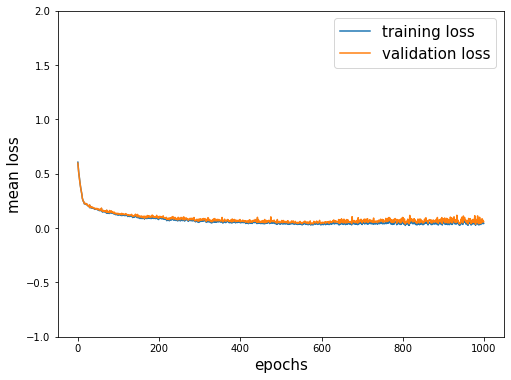

In [267]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
epochs = np.arange(trainer.max_epochs)
ax.plot(epochs,train_loss,label='training loss')
ax.plot(epochs,val_loss,label='validation loss')
ax.set_xlabel('epochs',fontsize=15)
ax.set_ylabel('mean loss',fontsize=15)
ax.legend(fontsize=15)
ax.set_ylim([-1,2])
plt.show()

In [301]:
x_test.shape

torch.Size([843, 299])

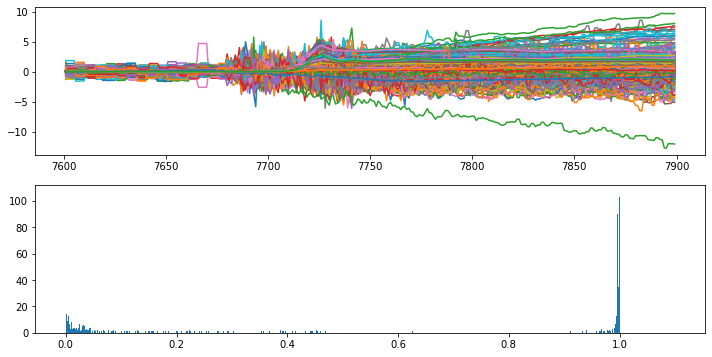

In [374]:
y_score = model(x_test).detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()

fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(spec.feature, x_test.detach().cpu().numpy().T)
axs[1].hist(y_score,bins=np.arange(0,1.1,0.001))
plt.show()

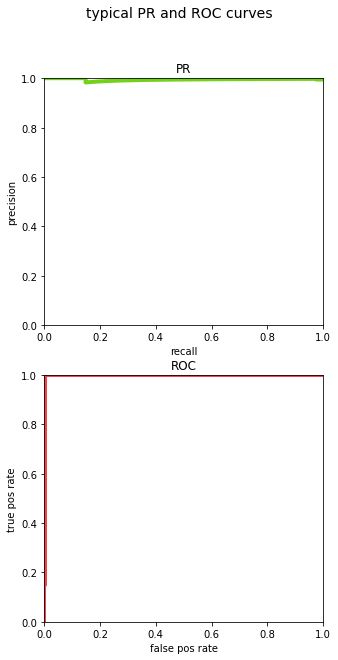

In [376]:
GREEN = '#72d218'
RED = '#f4424b'
BLUE = '#72bdff'


def label_plot(ax, is_pr=True):
    x, y = (('recall', 'precision')
            if is_pr else
            ('false pos rate', 'true pos rate'))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    
def plot_pr_and_roc(y_true, y_pred, title):
    p, r, _ = precision_recall_curve(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    fig, axs = plt.subplots(2, 1, figsize=(5,10))
    axs[0].plot(r, p, lw=4, color=GREEN)
    axs[0].set_title('PR')
    label_plot(axs[0], is_pr=True)

    axs[1].plot(fpr, tpr, lw=4, color=RED)
    axs[1].set_title('ROC')
    label_plot(axs[1], is_pr=False)

    fig.suptitle(title, fontsize=14)
    
plot_pr_and_roc(y_true, y_score, title='typical PR and ROC curves')

In [320]:
y_score.shape

(843, 1)

386/843


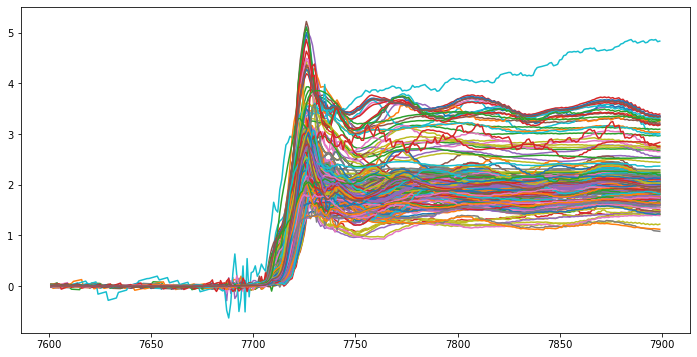

In [330]:
plot_select = (y_score > 0.8).reshape(-1)
fig, ax = plt.subplots(figsize=(12,6))
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))
for i,d in enumerate(x_test.detach().cpu().numpy()[plot_select]):
    ax.plot(spec.feature, d)

29/843


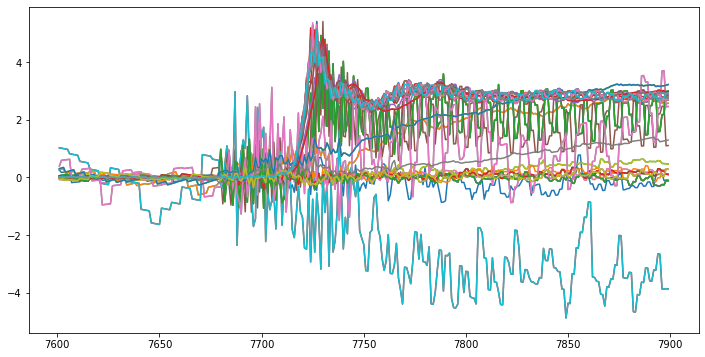

In [329]:
plot_select = ((y_score > 0.3) & (y_score <= 0.5)) .reshape(-1)
fig, ax = plt.subplots(figsize=(12,6))
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))
random_select = list(np.random.randint(plot_select.sum(),size=50))
for i,d in enumerate(x_test.detach().cpu().numpy()[plot_select][random_select]):
    ax.plot(spec.feature, d)

403/843


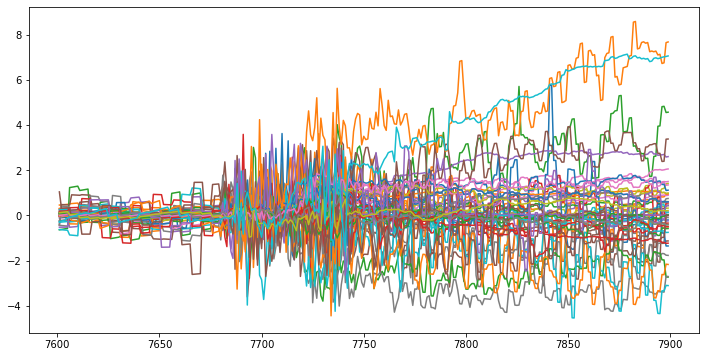

In [316]:
plot_select = (y_score <0.2).reshape(-1)
random_select = np.random.randint(plot_select.sum(),size=50)
fig, ax = plt.subplots(figsize=(12,6))
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))
for i,d in enumerate(x_test.detach().cpu().numpy()[plot_select][random_select]):
    ax.plot(spec.feature, d)

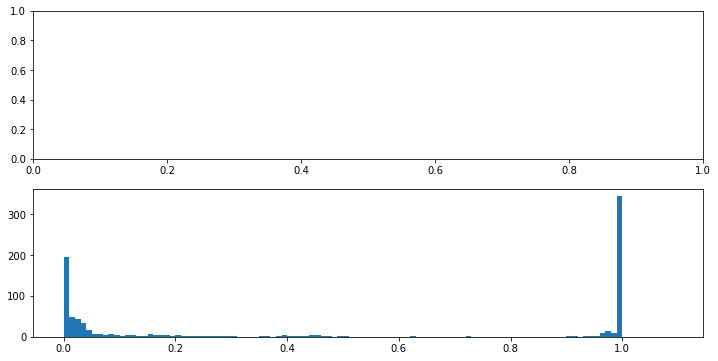

In [315]:
y_score = model(x_test).detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()

fig, axs = plt.subplots(2,1, figsize=(12,6))
# axs[0].plot(spec.feature, x_test[:,0,:].detach().cpu().numpy().T)
axs[1].hist(y_score,bins=np.arange(0,1.1,0.01))
plt.show()

In [332]:
norm_left = 7600
norm_right = 8000

with open("e{}-{}_grid400_spec_norm.pkl".format(int(norm_left),int(norm_right)),'rb') as f:
    spec_norm = pickle.load(f)
feature_grid = spec_norm['feature_grid']
energy_select = (feature_grid>7600) & (feature_grid<7900)

red_norm = spec_norm['spec'][:,energy_select]
feature_grid = spec_norm['feature_grid'][energy_select]
# read predicted labels from Neural networks
with open("e{}-{}_grid400_prediction.pkl".format(int(norm_left),int(norm_right)),'rb') as f:
    result = pickle.load(f)
    
labels = result['label']
sets = np.array(result['set'])

In [333]:
data_to_pred = tensor(red_norm[sets=='test'],
                      dtype=torch.float, device=torch.device('cuda'),requires_grad=True)

In [337]:
x_test_loss.shape

torch.Size([18386, 299])

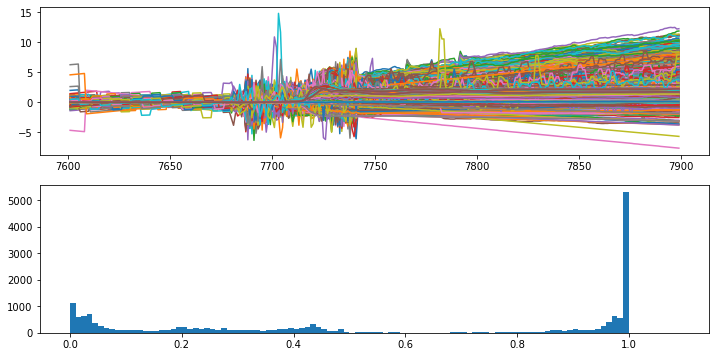

In [336]:
score = model(x_test_loss).detach().cpu().numpy()
fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(spec.feature, x_test_loss.detach().cpu().numpy().T)
axs[1].hist(score,bins=np.arange(0,1.1,0.01))
plt.show()

8477/18386


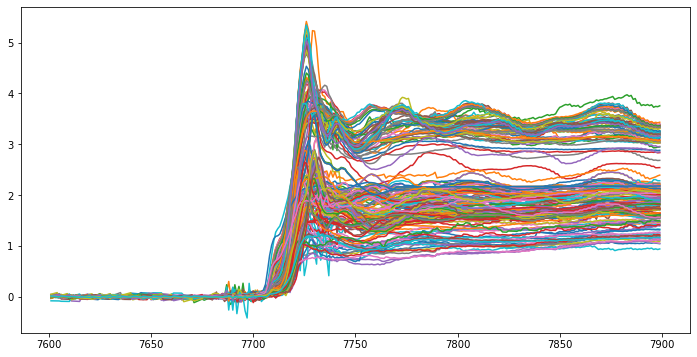

In [358]:
plot_select = ((score > 0.8) & (score <= 1.0)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=200))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

258/18386


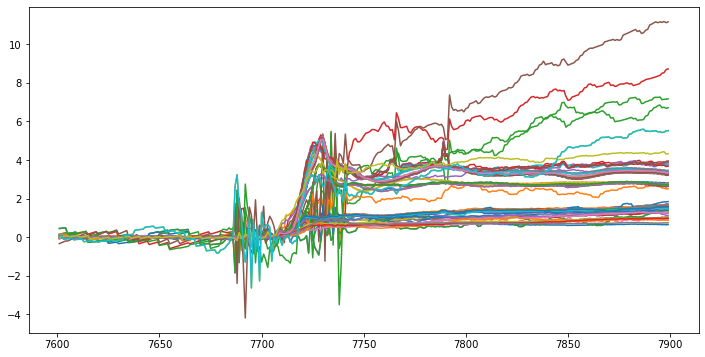

In [283]:
plot_select = ((score > 0.6) & (score < 0.8)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

640/18386


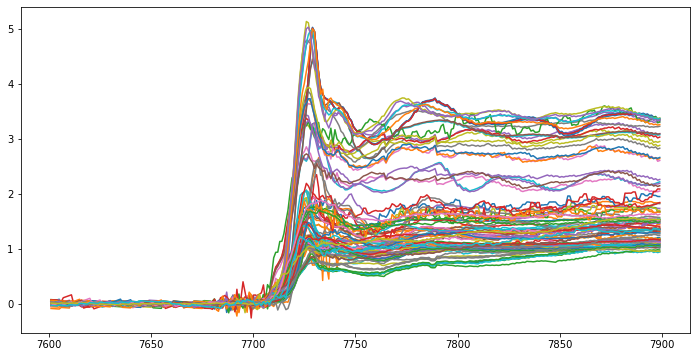

In [284]:
plot_select = ((score > 0.8) & (score < 0.9)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

7837/18386


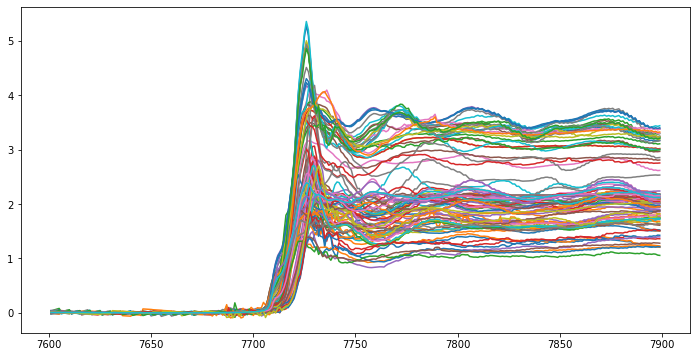

In [286]:
plot_select = ((score > 0.9) & (score <= 1.0)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

2144/18386


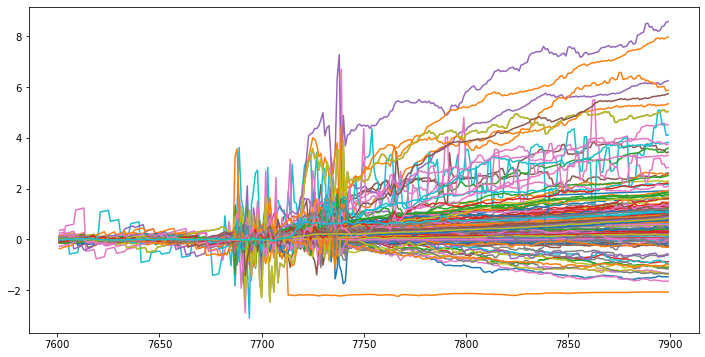

In [373]:
plot_select = ((score > 0.15) & (score <= 0.3)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=200))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

1111/18386


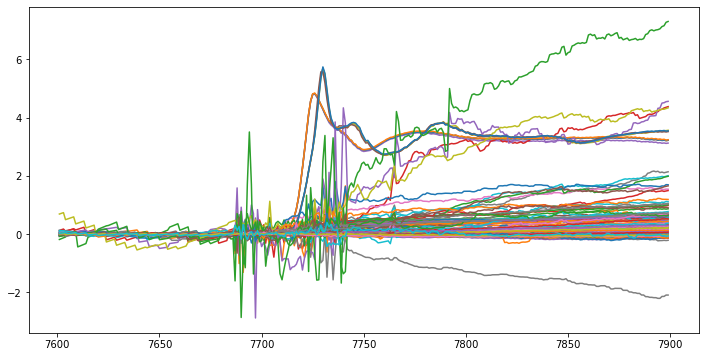

In [368]:
plot_select = ((score > 0.3)&(score <= 0.4)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

1492/18386


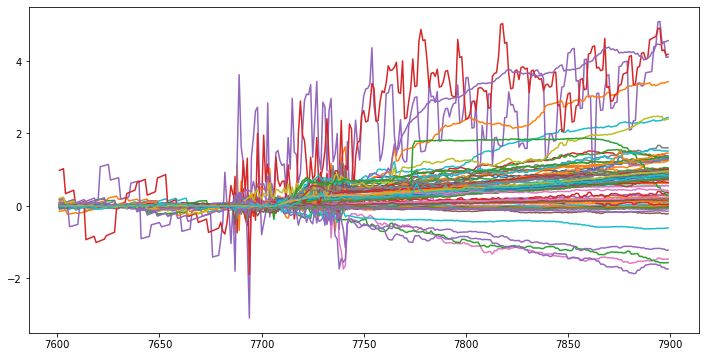

In [299]:
plot_select = ((score > 0.2) & (score <= 0.3)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

1123/18386


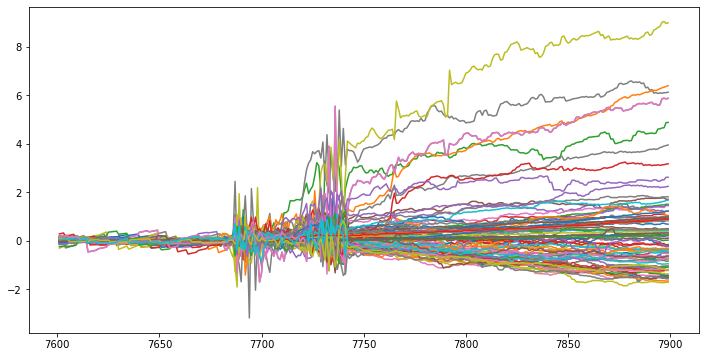

In [298]:
plot_select = ((score > 0.1) & (score <= 0.2)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

4224/18386


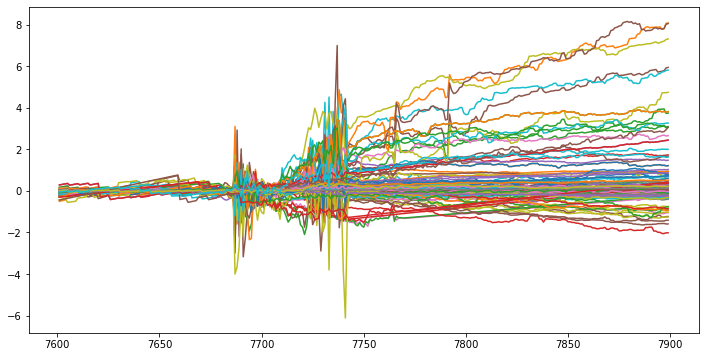

In [297]:
plot_select = ((score > 0) & (score <= 0.1)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.sum(),size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[plot_select].detach().cpu().numpy()[random_select]):
    ax.plot(spec.feature, d)

In [ ]:
model = Xas2QualityCNN(output_size=1, dropout_rate=0.4)

In [207]:
# N_sample = len(data)
# index = np.arange(N_sample)
# test_mask = ~(masks['good']|masks['bad'])

# # label score (1 or 0) or predicted scores for all the data
# labels = np.zeros(N_sample,dtype=float)
# labels[masks['good']] = int(1)
# labels[masks['bad']] = int(0)
# labels[index[test_mask]] = y_test_pred.reshape(-1)

# # train/test label for all the date
# sets = ['train'] * N_sample
# for i in index[test_mask]: sets[i] = 'test'

# result = {'set': sets,
#           'label': labels}

# with open("e{}-{}_grid400_prediction.pkl".format(int(norm_left),int(norm_right)),'wb') as f:
#     pickle.dump(result,f)